<br> 
<span style="float: right; color: rgb(128, 128, 128); font-size:150%" >  <strong> Final Project - Milestone 1</span>
<span style="float: left; color: rgb(128, 128, 128); font-size:150%"> <strong>  42186 Model-based machine learning (F20)</span>    
    <br>  
  
    
    
  <span style="float: right; color: rgb(128, 128, 128)" >  <strong> Students:</span>
  <span style="float: left; color: rgb(128, 128, 128)"> <strong>  Professors:</span>
<div> 
      <br>  
<div>
  <span style="float: right" > Guðlaug Erlendsdóttir, s185717</span> 
  <span style="float: left"> Filipe Rodrigues</span>
<div> 
    <br>
  <span style="float: right" > Matthías Karl Karlsson, s182306</span> 
  <span style="float: left"> Francisco Camara Pereira</span>
    <br>
<div style="text-align: right"> Steinn Orri Erlendsson, s153716</div>
    
______________

**The Dirichlet Distribution**



**Latent Dirichlet Allocation**

## Table of Contents

### [1. Description of Project](#one)

* ####  [1.1. Research Question](#ResearchQuestion)

### [2. Data](#two)

* #### [2.1 Data Collection and Preprocessing](#two.one)

### [3.Natural Language Preprocessing](#three)

### [4. Descriptive Stats](#four)

### [5. Linear Regression - For comparison](#reg)

### [6. Generative Story & PGM](#six)

### [7. Inital STAN Model](#eight)

### [ Conclusion](#conclusion)


## The Simpsons - Topic Modeling with Latent Dirichlet Allocation(LDA)


In this notebook, topic modeling through Latent Dirichlet Allocation(LDA) is used in order to try uncover the topics that have come up on episodes of The Simpsons through the years. 

Attributes such as `rating` and `viewers` are extracted from [IMDB](IMDB) for the first 600 episodes of The Simpsons. 
Then, for each of these episodes, the description is scraped from [The Simpsons Fandom](page) page. 
There is a lot of data cleaning to be done, as there are a lot of missing values that resulted from the web scraping due to some inconstistency in the pages' setup. 
Natural Language Processing is deployed in order to represent the textual data better. Each episode's description was put through *TF-IDF analysis* in order to obtain a better representation of their description. 

By using LDA for topic modeling, the episodes can be seen as a mixture of topics, and therefore a relationhip between what is happening in the episode and its rating could potentially be made. Finally, a simple linear regression is used for comparison of the model's performance.

---


# 1. Description of Project<a class="anchor" id="one"></a>

For those that have ever watched the television show *The Simpsons*, it is quite known that the quality of episodes have dwindled over the past years. The show has been running for 30 years and it has long gone past its glory days. But what is the reason behind this decline in quality? In this notebook, the topics of each episode of *The Simpsons* is investigated and through *topic modeling* episodes are clustered together in order to see whether the topics of episodes have anything to do with their respective ratings. 

Ratings for 600 episodes were collected from [IMDB](https://www.imdb.com/) and descriptions for each of those episodes was collected from [The Simpsons Wiki Fanpage](https://simpsons.fandom.com/wiki/List_of_Episodes). This information, along with additional information collected from [Wikipedia](https://www.wikipedia.org) such as viewers per episode and airdate, was used in order to create a data set.

The probabilistic topic model *Latent Dirichlet Allocation* was used in order to extract topic proportions and allocations for each episode. These topics were then investigated in order to see if there is any apparent relationship between the topic of episodes over the years and their declining ratings. 

## 1.1. Research Question<a class="anchor" id="ResearchQuestion"></a>

By using *Topic Modeling* and *Latent Dirichlet Allocation*, we hope to uncover some of the hidden features of the episodes. In general, an episode's rating is related to what is happening in the episode. We want to find if there a relationship between the topic of episodes and their respective ratings, so our research question is;

> How do the topic proportions align with the episodes and can they be used to determine an episode's rating?

If the topic allocations and proportions of an episode can help determine an episode's rating, not only have be created a better linear regression model, but we have proven a hypothesis which does seem logical. 

# 2. Data<a class="anchor" id="two"></a>

In this section, the method of collecting and preprocessing both the *ratings* and *description* for each episode is shown. All of the data is collected through web scraping. The websites that were scraped were [IMDB](https://www.imdb.com), [Wikipedia](https://www.wikipedia.org), and [The Simpsons Fandom Wiki Page](https://simpsons.fandom.com/wiki/List_of_Episodes). 

#### Importing packages

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import urllib.request
import io
import re
import os
import os.path
import nltk, re, pprint
from nltk.tokenize import RegexpTokenizer
import sklearn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import collections
import colorsys
import warnings
warnings.filterwarnings("ignore")
from nltk import sent_tokenize
from nltk.stem import SnowballStemmer 
from nltk.tokenize import word_tokenize 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import Image
sns.set(style="ticks", color_codes=True)
plt.rcParams['figure.figsize'] = (16, 10)
import pystan
import pystan_utils
#make margins smaller 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 95% !important; }</style>"))

## 2.1 Data Collection and Preprocessing<a class="anchor" id="two.one"></a>

### Episode Information <a class="anchor" id="two.one.one"></a>

Getting all episode names, dates and relevant information is possible by scraping Wikipedia. This will serve as a basis for the episode information which will be used throughout the project. 

In [2]:
episode_1_20_url = 'https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes_(seasons_1%E2%80%9320)#Episodes'
episode_21_31_url = "https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes"

In [3]:
res = requests.get(episode_1_20_url).text
soup = BeautifulSoup(res,'html')
arr = []
next_season = 1
for table in soup.find_all('table', class_='wikiepisodetable'):
    if(table.previous.previous.previous.text != 'The Simpsons Movie'):
        season = table.previous.previous.previous.text.split('(')[1].split(')')[0].split(" ")[1]
        for row in table.find_all('tr')[1::1]:
            data = row.find_all(['th','td'])
            no = data[0].text
            no_in_season = data[1].text
            episode_name = data[2].text[1:len(data[2].text)-1] #Remove the " " 
            airdate = data[5].text
            viewers = data[7].text.split("[")[0]
            arr.append([no,season,no_in_season,episode_name,airdate,viewers])
df_1 = pd.DataFrame(arr)
df_1.columns = ['no_overall','season','no_in_season','episode_name','airdate','viewers (millions)']

Seasons 1 to 20:

In [4]:
df_1.head(3)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions)
0,1,1,1,Simpsons Roasting on an Open Fire,"December 17, 1989 (1989-12-17)",26.7
1,2,1,2,Bart the Genius,"January 14, 1990 (1990-01-14)",24.5
2,3,1,3,Homer's Odyssey,"January 21, 1990 (1990-01-21)",27.5


In [5]:
df_1.tail(3)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions)
438,439,20,19,"Waverly Hills, 9-0-2-1-D'oh","May 3, 2009 (2009-05-03)",6.75
439,440,20,20,Four Great Women and a Manicure,"May 10, 2009 (2009-05-10)",5.16
440,441,20,21,Coming to Homerica,"May 17, 2009 (2009-05-17)",5.86


Now, the rest of the seasons are retrieved:

In [6]:
res = requests.get(episode_21_31_url).text
soup = BeautifulSoup(res,'html')
arr = []
next_season = 1
for table in soup.find_all('table', class_='wikiepisodetable'):
    if(table.previous.previous.previous.text != 'The Longest Daycare' and table.previous.previous.previous.text):
        season = table.previous.previous.previous.text.split('(')[1].split(')')[0].split(" ")[1]
        for row in table.find_all('tr')[1::1]:
            data = row.find_all(['th','td'])
            no = data[0].text
            no_in_season = data[1].text
            episode_name = data[2].text[1:len(data[2].text)-1] #Remove the " " 
            airdate = data[5].text
            viewers = data[7].text.split("[")[0]
            arr.append([no,season,no_in_season,episode_name,airdate,viewers])
        if(season=='30'):
            break
df_2 = pd.DataFrame(arr)
df_2.columns = ['no_overall','season','no_in_season','episode_name','airdate','viewers (millions)']

Seasons 21 to 30:

In [7]:
df_2.head(3)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions)
0,442,21,1,Homer the Whopper,"September 27, 2009 (2009-09-27)",8.31
1,443,21,2,Bart Gets a 'Z',"October 4, 2009 (2009-10-04)",9.32
2,444,21,3,The Great Wife Hope,"October 11, 2009 (2009-10-11)",7.5


In [8]:
df_2.tail(3)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions)
217,660,30,21,D'oh Canada,"April 28, 2019 (2019-04-28)",1.93
218,661,30,22,Woo-Hoo Dunnit?,"May 5, 2019 (2019-05-05)",1.79
219,662,30,23,Crystal Blue-Haired Persuasion,"May 12, 2019 (2019-05-12)",1.50


Concatinating them together will create the final dataframe for the episodes:

In [9]:
df_episodes = pd.concat([df_1,df_2])

In [10]:
df_episodes.reset_index(inplace=True)
df_episodes.drop('index',axis=1,inplace=True)

df_episodes['no_overall'] = df_episodes['no_overall'].apply(lambda x: int(x))
df_episodes['season'] = df_episodes['season'].apply(lambda x: int(x))
df_episodes['no_in_season'] = df_episodes['no_in_season'].apply(lambda x: int(x))

It is necessary to clean **season 28**, here episode **607**, are two seperate episodes.

In [11]:
df_episodes.iloc[607]

no_overall                                   608609
season                                           28
no_in_season                                   1213
episode_name          The Great Phatsby Parts 1 & 2
airdate               January 15, 2017 (2017-01-15)
viewers (millions)                             6.90
Name: 607, dtype: object

Splitting the episode up into episode **608** and **609** will make the data make more sense, as the overall episode count will be linear. 

In [12]:
df_episodes.drop(607,axis=0,inplace=True)

In [13]:
insert_into = pd.DataFrame(data = [{'no_overall':608, 'season':28,'no_in_season': 12, 
                            'episode_name':'The Great Phatsby','airdate': 'January 15, 2017 (2017-01-15)', 
                            'viewers (millions)': 6.90}, {'no_overall':609, 'season':28,'no_in_season': 13, 
                            'episode_name':'The Great Phatsby','airdate': 'January 15, 2017 (2017-01-15)', 
                            'viewers (millions)': 6.90}], index=[607,608])

df_episodes = pd.concat([df_episodes.iloc[:608], insert_into, df_episodes[608:]])

### Episode Ratings <a class="anchor" id="two.one.two"></a>

Getting the ratings for each episode is possible by scraping IMDB. There exist several pages of ratings for the series on IMDB. Going through each one of them will yield every episode's rating:

In [14]:
imdb_ratings_url = 'https://www.imdb.com/list/ls052175596/?st_dt=&mode=simple&page={}&ref_=ttls_vw_smp&sort=release_date,asc'
pages = range(1,8)

In [15]:
ratings = []
for page in range(1,8):
    url = imdb_ratings_url.format(page)
    res = requests.get(url).text
    soup = BeautifulSoup(res,'html')
    container = soup.find('div',class_='lister')
    for item in container.find_all('div', class_='lister-item'):
        as_ = item.find('span',class_='lister-item-header').find_all('a')
        episode_name = as_[1].text
        rating = item.find('div',class_='col-imdb-rating').text.strip()
        ratings.append([episode_name,rating])

df_ratings = pd.DataFrame(ratings)
df_ratings.columns = ['episode_name','IMDB rating']

In [16]:
df_ratings.tail(10)

,episode_name,IMDB rating
671,Hail to the Teeth,6
672,The Miseducation of Lisa Simpson,6.6
673,Frinkcoin,5.9
674,Bart the Bad Guy,7.3
675,Screenless,6.6
676,Better Off Ned,6.5
677,Highway to Well,7
678,The Incredible Lightness of Being a Baby,6.3
679,Warrin' Priests,6
680,Warrin' Priests Part 2,5.7


For this particular project, only the first 660 episodes will be investigated. This decision was made as the last episodes do not have as much description written about them as they are quite new. 

In [17]:
df_ratings = df_ratings[:661]

In [18]:
df_ratings.tail(2)

,episode_name,IMDB rating
659,Woo-Hoo Dunnit?,5.9
660,Crystal Blue-Haired Persuasion,5.8


Concatinating these two DataFrames will yield more informative data. However, a simple merge on the names will not do because the names are not exactly identical on IMDB and Wikipedia. The `NaN` values will be looked at and manually fixed: 

In [19]:
df_episodes_ratings = pd.merge(df_episodes, df_ratings, on='episode_name',how='left')

The following episodes do not get a rating after the join because the naming convention are different between IMDB and Wikipedia.

In [20]:
df_episodes_ratings[df_episodes_ratings['IMDB rating'].isna()]

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions),IMDB rating
13,14,2,1,"Bart Gets an ""F""","October 11, 1990 (1990-10-11)",33.6,NaN
21,22,2,9,Itchy & Scratchy & Marge,"December 20, 1990 (1990-12-20)",22.2,NaN
28,29,2,16,"Bart's Dog Gets an ""F""","March 7, 1991 (1991-03-07)",23.9,NaN
88,89,5,8,Boy-Scoutz 'n the Hood,"November 18, 1993 (1993-11-18)",20.1,NaN
90,91,5,10,"$pringfield (or, How I Learned to Stop Worryin...","December 16, 1993 (1993-12-16)",17.9,NaN
123,124,6,21,The PTA Disbands!,"April 16, 1995 (1995-04-16)",11.8,NaN
127,128,6,25,Who Shot Mr. Burns? (Part One),"May 21, 1995 (1995-05-21)",15.0,NaN
128,129,7,1,Who Shot Mr. Burns? (Part Two),"September 17, 1995 (1995-09-17)",16.0,NaN
130,131,7,3,Home Sweet Homediddly-Dum-Doodily,"October 1, 1995 (1995-10-01)",14.5,NaN
134,135,7,7,King-Size Homer,"November 5, 1995 (1995-11-05)",17.0,NaN


A list of the names of the episodes that are missing their ratings can be created: 

In [21]:
missing = df_episodes_ratings[df_episodes_ratings['IMDB rating'].isna()].reset_index()
missing_episodes = missing['index']
for episode in missing_episodes:
    print(df_ratings.iloc[episode]['episode_name'],df_ratings.iloc[episode]['IMDB rating'])

Bart Gets an F 8.2
Itchy and Scratchy and Marge 8.1
Bart's Dog Gets an F 7.5
Boy Scoutz 'n the Hood 8.7
$pringfield (Or, How I Learned to Stop Worrying and Love Legalized Gambling) 8.6
The PTA Disbands 8.1
Who Shot Mr. Burns? Part One 9.2
Who Shot Mr. Burns? Part Two 9
Home Sweet Home-Dum-Diddly Doodily 8.4
King Size Homer 9
The Simpsons 138th Episode Spectacular! 7.5
Raging Abe Simpson and His Grumbling Grandson in 'The Curse of the Flying Hellfish' 8.4
Summer of 4'2" 8.4
El Viaje Misterioso De Nuestro Jomer 8.6
Homer vs. the 18th Amendment 8.9
Lisa Gets an 'A' 8.1
Homer Simpson in: 'Kidney Trouble' 7.3
Marge Simpson in 'Screaming Yellow Honkers' 7.3
The Old Man and the 'C' Student 7.3
Thirty Minutes Over Tokyo 8
Alone Again, Natura-Diddly 7.7
Lisa the Treehugger 7.1
Homr 8.1
Hungry Hungry Homer 7.5
Bye Bye Nerdy 6.6
I Am Furious Yellow 7.7
Papa's Got a Brand New Badge 7.8
Bart vs. Lisa vs. 3rd Grade 7.1
Today, I Am a Clown 6.4
I, (Annoyed Grunt)-Bot 7.2
Co-Dependent's Day 6.7
Thank G

As can be seen by comparing the two lists, these are the episodes that are missing a rating in the final dataframe. Now, an array can be created with the ratings of these episodes, extracted from `df_ratings`. 

In [22]:
missing_ratings = []
for episode in missing_episodes:
    missing_ratings.append([episode,df_episodes.iloc[episode]['episode_name'],df_ratings.iloc[episode]['IMDB rating']])

In [23]:
for episode in missing_ratings: 
    index = episode[0]
    rating = episode[2]
    df_episodes_ratings.at[index, 'IMDB rating'] = rating

In [24]:
df_episodes_ratings[df_episodes_ratings['IMDB rating'].isna()]

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions),IMDB rating


The DataFrame holding each episode's information along with it's rating is now complete, but the airdate column can use a little bit of cleaning:

In [25]:
df_episodes_ratings.head(2)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions),IMDB rating
0,1,1,1,Simpsons Roasting on an Open Fire,"December 17, 1989 (1989-12-17)",26.7,8.2
1,2,1,2,Bart the Genius,"January 14, 1990 (1990-01-14)",24.5,7.7


In [26]:
df_episodes_ratings['year'] = df_episodes_ratings['airdate'].apply(lambda x: str(x).split("(")[1].split("-")[0])
df_episodes_ratings['month'] = df_episodes_ratings['airdate'].apply(lambda x: str(x).split("(")[1].split("-")[1].split('-')[0])
df_episodes_ratings['day'] = df_episodes_ratings['airdate'].apply(lambda x: str(x).split("(")[1].split("-")[2].replace(")",""))

In [27]:
df_episodes_ratings.head(2)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions),IMDB rating,year,month,day
0,1,1,1,Simpsons Roasting on an Open Fire,"December 17, 1989 (1989-12-17)",26.7,8.2,1989,12,17
1,2,1,2,Bart the Genius,"January 14, 1990 (1990-01-14)",24.5,7.7,1990,01,14


The Airdate column can now be dropped:

In [28]:
df_episodes_ratings.drop('airdate',axis=1,inplace=True)

And finally, the IMDB rating column should hold float values:

In [29]:
df_episodes_ratings['IMDB rating'] = df_episodes_ratings['IMDB rating'].apply(lambda x: float(x))

There are still some `NaN` values in the column `viewers (millions)`

In [30]:
df_episodes_ratings[df_episodes_ratings['viewers (millions)'] == 'N/A']

,no_overall,season,no_in_season,episode_name,viewers (millions),IMDB rating,year,month,day
159,160,8,7,Lisa's Date with Density,N/A,7.8,1996,12,15
160,161,8,8,Hurricane Neddy,N/A,8.8,1996,12,29
172,173,8,20,The Canine Mutiny,N/A,7.6,1997,04,13


These values will be set as the average of the viewers for the season that they belong to.

In [31]:
avg_season_8 = np.average([float(viewer) for viewer in df_episodes_ratings[(df_episodes_ratings['viewers (millions)'] != 'N/A') & (df_episodes_ratings['season'] == 8)]['viewers (millions)']])

The values that need to be filled in are in places 159, 160 and 172:

In [32]:
fill_na_indices = [index for index in df_episodes_ratings[df_episodes_ratings['viewers (millions)'] == 'N/A'].reset_index()['index']]

In [33]:
for index in fill_na_indices:    
    df_episodes_ratings.at[index,'viewers (millions)'] = avg_season_8

This column should also hold float values.

In [34]:
df_episodes_ratings['viewers (millions)'] = df_episodes_ratings['viewers (millions)'].apply(lambda x: float(x))

In [35]:
df_episodes_ratings.isna().sum()

no_overall            0
season                0
no_in_season          0
episode_name          0
viewers (millions)    0
IMDB rating           0
year                  0
month                 0
day                   0
dtype: int64

In [36]:
df_episodes_ratings.to_csv('episode_ratings.csv')

### Simpsons.fandom Pages of Each Episode <a class="anchor" id="two.one.four"></a>

In order to scour through each episode's description, scraping a Wiki fan-page of the series is necessary.

In [37]:
wiki_url = 'https://simpsons.fandom.com/wiki/List_of_Episodes'

In [38]:
links_array = []
res = requests.get(wiki_url).text
soup = BeautifulSoup(res,'html')
no_overall = 1
for table in soup.find_all('table', class_='wikitable')[1:31]: #Skip the overview table and only take the first 30 seasons
    for row in table.find_all('tr'):
            links = row.find_all('a')
            for link in links:
                if(link['href'].split('/wiki/')[1] != 'The_Simpsons_Movie'):
                    links_array.append([no_overall,link['href'].split('/wiki/')[1]])
                    no_overall = no_overall + 1

In [39]:
df_episode_wiki = pd.DataFrame(links_array)
df_episode_wiki.columns = ['no_overall','wiki_link']

In [40]:
df_episode_wiki

,no_overall,wiki_link
0,1,Simpsons_Roasting_on_an_Open_Fire
1,2,Bart_the_Genius
2,3,Homer%27s_Odyssey
3,4,There%27s_No_Disgrace_Like_Home
4,5,Bart_the_General
...,...,...
656,657,Girl%27s_in_the_Band
657,658,I%27m_Just_a_Girl_Who_Can%27t_Say_D%27oh
658,659,D%27oh_Canada
659,660,Woo-hoo_Dunnit%3F


Again, the episode 'The Great Phatsby' (episode 608/609), is causing problems. It can be solved as we did before:

In [41]:
phatsby_insert = pd.DataFrame({'no_overall':609, 'wiki_link':'The_Great_Phatsby'},index=[608])
phatsby_insert
df_episode_wiki = pd.concat([df_episode_wiki.iloc[:608], phatsby_insert, df_episode_wiki[608:]])
df_episode_wiki.reset_index(inplace=True, drop=True)
df_episode_wiki_no_correction = df_episode_wiki.iloc[609:]
df_episode_wiki_no_correction['no_overall'] = df_episode_wiki_no_correction['no_overall'].apply(lambda x: x+1)
df_episde_wiki = pd.concat([df_episode_wiki.iloc[:608], df_episode_wiki_no_correction])

In [42]:
df_episodes_ratings = pd.merge(df_episodes_ratings,df_episode_wiki)

In [43]:
df_episodes_ratings.head(5)

,no_overall,season,no_in_season,episode_name,viewers (millions),IMDB rating,year,month,day,wiki_link
0,1,1,1,Simpsons Roasting on an Open Fire,26.7,8.2,1989,12,17,Simpsons_Roasting_on_an_Open_Fire
1,2,1,2,Bart the Genius,24.5,7.7,1990,01,14,Bart_the_Genius
2,3,1,3,Homer's Odyssey,27.5,7.4,1990,01,21,Homer%27s_Odyssey
3,4,1,4,There's No Disgrace Like Home,20.2,7.7,1990,01,28,There%27s_No_Disgrace_Like_Home
4,5,1,5,Bart the General,27.1,8.0,1990,02,04,Bart_the_General


### Creating Text Files of Episodes <a class="anchor" id="two.one.five"></a>

Here, each description is fetched and saved as a text file in order to attach them to the data set later. Below, a short description is fetched from another section of each episode's wiki website. The following image explains the process. The upper description of the episode is much shorter and will be scraped separately. The latter is a much longer, thorough description and will be scraped below. 

![scrape](scrape.png)

In [44]:
if not os.path.exists('synopsis'):
        os.mkdir('synopsis')
        
not_full_story = ['Mr._Spritz_Goes_to_Washington', 
                  'Three_Gays_of_the_Condo', 
                  'The_Fat_and_the_Furriest', 
                  'Today,_I_Am_a_Clown', 
                  'Simple_Simpson', 
                  'Fat_Man_and_Little_Boy', 
                  'My_Fare_Lady', 
                  'To_Courier_with_Love', 
                  'Lisa_Gets_the_Blues', 
                  'Girl%27s_in_the_Band',
                  'A_Star_is_Born-Again',
                  'Milhouse_Doesn%27t_Live_Here_Anymore']

for season in df_episodes_ratings['season'].unique():
    if not os.path.exists('synopsis/'+'season'+str(season)):
        os.mkdir('synopsis/'+'season'+str(season))

save_path = os.getcwd()+'/synopsis/'
for episode in df_episodes_ratings['wiki_link']:
    syn = " "
    
    res = requests.get("https://simpsons.fandom.com/wiki/{}".format(episode)).text
    ep_number = df_episodes_ratings[df_episodes_ratings['wiki_link']==episode]['no_overall'].values[0]
    season = int(df_episodes_ratings[df_episodes_ratings['wiki_link']==episode]['season'].values[0])
    
    soup = BeautifulSoup(res,'html')
    
    # Remove all images
    figs = soup.findAll('figure')
    for fig in figs:
        fig.decompose()
        
    h3s = soup.findAll('h3')
    for h3 in h3s:
        h3.decompose()

    if(episode in not_full_story):
        parent = soup.find('span', {'id':'Synopsis'}).parent
        sibling = parent.next_sibling
        while(sibling.name == 'p' or sibling.name is None or sibling.name =='a' or sibling.name==''):
            if(sibling.name == 'p' or sibling.name=='a'):
                syn += ' ' + str(sibling.text)
                sibling = sibling.next_sibling
            else:
                sibling = sibling.next_sibling

            
    else:

        if(soup.find('span', {'id':'Full_Story'})):
            
            parent = soup.find('span', {'id':'Full_Story'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling

        elif(soup.find('span', {'id':'The_Story'})):
            
            parent = soup.find('span', {'id':'The_Story'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling
                    
        elif(soup.find('span', {'id':'Full_story'})):
            
            parent = soup.find('span', {'id':'Full_story'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling

        elif(soup.find('span', {'id':'Plot'})):
            
            parent = soup.find('span', {'id':'Plot'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name=='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling
                    
        elif(soup.find('span', {'id':'Full_Story.C2.A0'})):
            
            parent = soup.find('span', {'id':'Full_Story.C2.A0'}).parent
            sibling = parent.next_sibling

            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling

                    
    complete_name = os.path.join(os.path.expanduser('~'),save_path+'season'+str(season)+'/',str(ep_number)+'.txt')

    with io.open(complete_name, "w", encoding="utf-8") as f: 
        f.write(str(syn))
        f.close()

It is then necessary to copy episode 608 and create episode 609, as these two episodes are the same episode - often referred to as episode "608609". 

In [45]:
save_path = os.getcwd()+'/synopsis/season28/'
path = save_path+"608.txt"
text = io.open(path,'r',encoding='utf-8').read()
with io.open(save_path+'609.txt', "w", encoding="utf-8") as f: 
    f.write(str(text))
    f.close()

In [46]:
rows = []
for ep in df_episodes_ratings['no_overall']:
    season = df_episodes_ratings[df_episodes_ratings['no_overall']==ep]['season'].values[0]
    with io.open("synopsis/season{}/{}.txt".format(season,ep),'r', encoding='utf-8') as f:
        desc = f.read()
        desc = desc.lower()
        rows.append([ep,desc])
        f.close()

In [47]:
df_desc = pd.DataFrame(rows, columns = ['no_overall','desc'])

In [48]:
df_desc[df_desc['desc']==' ']

,no_overall,desc
167,168,
256,257,
321,322,
364,365,
430,431,
642,643,
645,646,
659,660,


#### Scraping for a small synopsis of each episode

As the descriptions for some episode might be quite long and cumbersome, we decided that obtaining a short *synopsis*, which is also represented on the same wiki website, could potentially be a better textual representation of each episode. We suspect that these textual representations of the epsiodes will differ quite a bit. The following scraping will be carried out in a very similar manner to what has been done above.

In [49]:
if not os.path.exists('short_synopsis'):
        os.mkdir('short_synopsis')

synopsis = []

for season in df_episodes_ratings['season'].unique():
    if not os.path.exists('short_synopsis/'+'season'+str(season)):
        os.mkdir('short_synopsis/'+'season'+str(season))

save_path = os.getcwd()+'/short_synopsis/'
for episode in df_episodes_ratings['wiki_link']:
    res = requests.get("https://simpsons.fandom.com/wiki/{}".format(episode)).text
    ep_number = df_episodes_ratings[df_episodes_ratings['wiki_link']==episode]['no_overall'].values[0]
    season = int(df_episodes_ratings[df_episodes_ratings['wiki_link']==episode]['season'].values[0])
    soup = BeautifulSoup(res,'html')
    if(episode == 'The_Old_Man_and_the_Key'): # An edge case
        syn=soup.find_all('p')[1].text
    elif(soup.find('span', {'id':'Synopsis'})):
        firstp = soup.find('span', {'id':'Synopsis'}).parent.findNext('p')
        syn = firstp.text
        while(firstp.nextSibling.name=='p'):
            syn = str(syn) + ' ' + firstp.nextSibling.text
            firstp = firstp.nextSibling
    elif(soup.find('span', {'id':'Synopsis.'})):
        syn = soup.find('span', {'id':'Synopsis.'}).parent.findNext('p').text
    elif(soup.find('span', {'id':'Summary'})):
        syn = soup.find('span', {'id':'Summary'}).parent.findNext('p').text
    complete_name = os.path.join(os.path.expanduser('~'),save_path+'season'+str(season)+'/',str(ep_number)+'.txt')
    with io.open(complete_name, "w", encoding="utf-8") as f: 
        f.write(str(syn))
        f.close()

In [50]:
save_path = os.getcwd()+'/short_synopsis/season28/'
path = save_path+"608.txt"
text = io.open(path,'r',encoding='utf-8').read()
with io.open(save_path+'609.txt', "w", encoding="utf-8") as f: 
    f.write(str(text))
    f.close()

In [51]:
rows = []
for ep in df_episodes_ratings['no_overall']:
    season = df_episodes_ratings[df_episodes_ratings['no_overall']==ep]['season'].values[0]
    with io.open("short_synopsis/season{}/{}.txt".format(season,ep),'r', encoding='utf-8') as f:
        desc = f.read()
        desc = desc.lower()
        rows.append([ep,desc])
        f.close()

In [52]:
df_short_desc = pd.DataFrame(rows, columns = ['no_overall','short_desc'])

In [53]:
df_short_desc.sample(5)

,no_overall,short_desc
333,334,"an accidental photo showing bart ""mooning"" the..."
349,350,in the middle of yet another one of their figh...
130,131,"after a series of misadventures, the simpson c..."
116,117,springfield's days are numbered when bart disc...
412,413,a new troublesome student named donny arrives ...


In [54]:
df_short_desc[df_short_desc['short_desc']==' ']

,no_overall,short_desc


## Characters

In [55]:
char_url = 'https://simpsons.fandom.com/wiki/Portal:All_Simpson_Characters'
res = requests.get(char_url).text
soup = BeautifulSoup(res,'html')
characters = []
for item in soup.find_all('div', class_='wikia-gallery-item'):
    wiki_link_container = item.find('div', class_='lightbox-caption')
    if(wiki_link_container.find('a',href=True)):
        wiki_link = wiki_link_container.find('a',href=True)['href']
        characters.append([item.text,wiki_link.replace('/wiki/','')])

In [56]:
df_char = pd.DataFrame(characters)
df_char.columns = ['name', 'char_wiki_link']

In [57]:
df_char['extra_wiki_link'] = df_char['char_wiki_link'].apply(lambda x: x.split('_')[0])

In [58]:
df_char.drop_duplicates(inplace=True)

One thing that must be noted is that some characters will not be referred to by their first name or even last name. For example, Abraham Simpson II will more often than not be referred to as *Grampa* or *Abe*. The same can be said about Charles Montgomery Burns will most likely be referred to as *Mr. Burns* or *Burns*. 

The character of Robert Terwilliger will most likely be referred to as *Sideshow Bob*. 

In [59]:
df_char.at[5,'name'] = 'Abe'
df_char.at[7,'name'] = 'Mr. Burns'

df_char.at[df_char.index[df_char['name'] == 'Robert Terwilliger'].tolist(), 'name'] = 'Sideshow Bob'

In [60]:
df_char.reset_index(inplace=True, drop=True)

In [61]:
first_names = df_char['name'].apply(lambda x: x.split())

In [62]:
fnames = []
for i,names in enumerate(first_names):
    rid = False
    for name in names:
        if('\'s' in name or 's\'' in name):
            rid = True
            break
        elif('the' in name):
            rid = False
        elif(name[0].islower()):
            if(name != 'bin' and name != 'von'):
                rid = True
                break
        elif(name.isdigit()):
            rid = True
            break
    if(rid):
        fname = ''
        for name in names:
            fname = fname + ' ' + name
        fnames.append(fname[1:])

In [63]:
df_char = df_char[~df_char['name'].isin(fnames)]

In [64]:
df_char['name'] = df_char['name'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x))
df_char['name'] = df_char['name'].apply(lambda x: re.sub(' +', ' ',x))

In [65]:
df_char['name'] = df_char['name'].apply(lambda x: x.replace("\"",""))

In [66]:
df_char.reset_index(inplace=True, drop=True)

In [67]:
# Characters that are irrelevant

rid_of_chars = [18, 120, 138, 255, 254, 253, 260, 276, 281, 287, 288, 295, 315, 482, 487,
                498, 501, 502, 504, 505, 517, 526, 529, 533, 542,543, 547, 557, 559, 561, 562, 
                599, 600, 601, 602, 603, 605, 606, 610, 611, 612, 613, 614, 615, 616, 617, 618, 
                619, 620, 621, 622, 607, 608, 579, 524, 604, 320, 593]

In [68]:
df_char.drop(rid_of_chars,inplace=True)

In [69]:
df_char.reset_index(inplace=True, drop=True)

In [70]:
df_char['name_split'] = df_char['name'].apply(lambda x: str(x).split(' '))
df_char['num_names'] = df_char['name_split'].apply(lambda x: len(x))

In [71]:
df_char.groupby('num_names').count()

,name,char_wiki_link,extra_wiki_link,name_split
num_names,,,,
1,92,92,92,92
2,371,371,371,371
3,94,94,94,94
4,9,9,9,9


In [72]:
irr_names = ['State','Black','Blue-Haired','Lawyer','Cowboy','Man','City','Capital','Database',
            'Boy','Little','Fat','Frog','God','Handsome','Judge','Guy','Book','Old','Man','Number','One',
            'Man','Rich','Veterinarian','Poor','Thief','Relative','Manager','Millionaire','Actor','Old',
            'Lady','New','Stop','Rest','Three','Unnamed','Baby','Blow','Horn','E-mail','Kid','White','Chew',
            'Strangles','Talking','Dog','Taquito','Gay','Colonel','Mathemagician','Fish']

In [73]:
names_to_remove = []
for name_split in df_char['name_split']:
    for name in name_split:
        if(len(name)>2 and '.' not in name and name!='The' and name!='the' and name not in irr_names):
            names_to_remove.append(name)

In [74]:
names_to_remove = list(set(names_to_remove))

## 3. Natural Language Processing<a class="anchor" id="three"></a>

In order to represent the text data better, some useful natural language processing methods will be deployed. 

First, all *stopwords*, along with the words "*episode*" and "*begins*" will be removed from the descriptions as they do not pertain any information about the episode itself, and appear quite often. 

Then, the description is split into *tokens* (words) and lastly we use stemming. For this particular objective, the Snowball (Porter2) stemmer will be used, as it is widely regarded as an improvement of the gentle Porter stemmer and is computationally faster [[REF]](https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg) Then the words can then be analyzed and very infrequent words will be removed, as will very frequent words. 

Character names will also appear quite often in the description of each epsiode. Here, we have chosen to remove them from the description. 

Stop wards will need to be created and appended with some special words that appear more often than they should, e.g. *episode* and *begins*, as this is a description of an episode on a Wiki page. Also, some character names will be added to the stopwords in order to remove them from the description later on. 

In [76]:
stop_words = ['episode','begins']
STOP_WORDS_EN = stopwords.words('english')
for word in STOP_WORDS_EN:
    stop_words.append(re.sub(r'[^\w]', ' ', word).replace(' ',''))

for word in ['episode','begins','homer','marge','bart','maggie','lisa','simpson','simpsons','burns',
             'milhouse','krusty','moe','skinner','wiggum','ned','flanders']:
    stop_words.append(word.lower())
for name in names_to_remove:
    stop_words.append(name.lower())

In [77]:
rows = []
stemmer = SnowballStemmer("english") 

for ep in df_episodes_ratings['no_overall']:
    season = df_episodes_ratings[df_episodes_ratings['no_overall']==ep]['season'].values[0]
    with io.open("synopsis/season{}/{}.txt".format(season,ep),'r', encoding='utf-8') as f:
        desc = f.read()
        desc = re.sub(r'[^\w]', ' ', desc)
        desc = re.sub(" \d+", " ", desc) #removing numbers
        desc = desc.replace(r' +',' ').replace('\n','')
        desc = desc.split(' ')
        desc = [word.lower() for word in desc if word.lower() not in stop_words]
        desc = [stemmer.stem(word.lower()) for word in desc if len(word)>2]
        rows.append([ep, desc])
        f.close()

In [78]:
df_desc = pd.DataFrame(rows, columns = ['no_overall','desc'])
df_desc = df_desc[:600]

Next, a column is created in order to display the length of each description for further analysis and processing of data.

In [79]:
df_desc['desc_len'] = df_desc['desc'].apply(lambda x: len(x))

In [80]:
df = df_episodes_ratings.merge(df_desc, on='no_overall')

In [81]:
rows = []
stemmer = SnowballStemmer("english") 

for ep in df_episodes_ratings['no_overall']:
    season = df_episodes_ratings[df_episodes_ratings['no_overall']==ep]['season'].values[0]
    with io.open("short_synopsis/season{}/{}.txt".format(season,ep),'r', encoding='utf-8') as f:
        desc = f.read()
        desc = re.sub(r'[^\w]', ' ', desc)
        desc = re.sub(" \d+", " ", desc) #removing numbers
        desc = desc.replace(r' +',' ').replace('\n','')
        desc = desc.split(' ')
        trun_desc = desc
        desc = [word.lower() for word in desc if word.lower() not in stop_words]
        desc = [stemmer.stem(word.lower()) for word in desc if len(word)>2]

        rows.append([ep, desc])
        f.close()

In [82]:
df_short_desc = pd.DataFrame(rows, columns = ['no_overall','short_desc'])
df_short_desc = df_short_desc[:600]

In [83]:
df_short_desc['short_desc_len'] = df_short_desc['short_desc'].apply(lambda x: len(x))

In [84]:
df = df.merge(df_short_desc, on='no_overall')

In [85]:
df.columns

Index(['no_overall', 'season', 'no_in_season', 'episode_name',
       'viewers (millions)', 'IMDB rating', 'year', 'month', 'day',
       'wiki_link', 'desc', 'desc_len', 'short_desc', 'short_desc_len'],
      dtype='object')

In [86]:
df.columns = ['no_overall', 'season', 'no_in_season', 'episode_name',
       'mil_viewers', 'rating', 'year', 'month', 'day',
       'wiki_link', 'desc', 'desc_len','short_desc','short_desc_len']

In [87]:
df.drop('wiki_link',axis=1,inplace=True)

In [88]:
df['mil_viewers'] = df['mil_viewers'].apply(lambda x: float(x))

In [89]:
df['day'] = df['day'].replace('22[a]','22')

In [90]:
df['no_overall'] = df['no_overall'].apply(lambda x: int(x))
df['no_in_season'] = df['no_in_season'].apply(lambda x: int(x))
df['season'] = df['season'].apply(lambda x: int(x))
df['year'] = df['year'].apply(lambda x: int(x))
df['month'] = df['month'].apply(lambda x: int(x))
df['day'] = df['day'].apply(lambda x: int(x))
df['rating'] = df['rating'].apply(lambda x: float(x))

The data set now looks like this, where the column *desc* is essentially a bag of words for each episode. 

In [91]:
df.sample(10)

,no_overall,season,no_in_season,episode_name,mil_viewers,rating,year,month,day,desc,desc_len,short_desc,short_desc_len
43,44,3,9,Saturdays of Thunder,24.70,7.9,1991,11,14,"[local, soap, box, derbi, held, heart, set, fi...",264,"[becom, deepli, immers, competit, soapbox, rac...",34
268,269,12,21,Simpsons Tall Tales,13.40,7.0,2001,5,20,"[win, trip, delawar, refus, pay, airport, tax,...",282,"[famili, win, trip, delawar, refus, pay, tax, ...",51
340,341,16,6,Midnight Rx,8.11,7.1,2005,1,16,"[reserv, air, space, museum, plant, compani, p...",268,"[cancel, plant, employe, prescript, drug, plan...",41
252,253,12,5,Homer vs. Dignity,15.00,7.0,2000,11,26,"[get, first, tri, cheat, order, get, mind, fac...",264,"[short, fund, approach, ever, wealthi, token, ...",19
265,266,12,18,Trilogy of Error,14.40,8.6,2001,4,29,"[everi, segment, garbag, truck, come, instead,...",488,"[thumb, sever, follow, breakfast, follow, thre...",36
389,390,18,12,Little Big Girl,8.27,6.7,2007,2,11,"[embelish, essay, heritag, class, project, pla...",404,"[unwit, save, control, fire, reward, drive, li...",31
179,180,9,2,The Principal and the Pauper,14.90,6.9,1997,9,28,"[celebr, anniversari, school, goe, smooth, man...",225,"[surpris, banquet, honor, twentieth, anniversa...",19
523,524,24,16,Dark Knight Court,4.89,6.9,2013,3,17,"[celebr, easter, school, play, howev, easter, ...",176,"[fals, accus, play, prank, school, defend, stu...",16
533,534,25,4,YOLO,4.20,6.4,2013,11,10,"[play, date, soon, finish, meccano, roller, co...",360,"[old, spanish, pen, friend, eduardo, barcelona...",16
217,218,10,15,"Marge Simpson in: ""Screaming Yellow Honkers""",8.60,7.3,1999,2,21,"[school, talent, show, teacher, show, open, te...",236,"[offer, new, canyonero, suv, embarrass, discov...",22


The following episodes are the episodes which do not have a description. These episodes will be removed from the dataset before any model is built.

In [92]:
len(df[df['desc_len']==0])

7

In [93]:
len(df[df['short_desc_len']==0])

0

In order to analyse the *dictionary* which will be used for the topic modelling, all words that appear over all descriptions of the episodes will be analyzed: 

In [94]:
desc_all_words = []
for desc in df['desc']:
    for word in desc:
        desc_all_words.append(word)

In [95]:
print("There is a total of {} unique words in the log description of all episodes".format(len(set(desc_all_words))))

There is a total of 10787 unique words in the log description of all episodes


The 50 most common words are:

In [96]:
Counter(desc_all_words).most_common(50)

[('get', 1387),
 ('tell', 1079),
 ('famili', 1015),
 ('take', 896),
 ('make', 894),
 ('back', 824),
 ('say', 778),
 ('tri', 723),
 ('find', 707),
 ('one', 689),
 ('howev', 658),
 ('see', 656),
 ('show', 621),
 ('home', 585),
 ('give', 563),
 ('school', 562),
 ('ask', 542),
 ('day', 525),
 ('hous', 510),
 ('new', 500),
 ('time', 496),
 ('come', 495),
 ('goe', 480),
 ('becom', 478),
 ('use', 476),
 ('plan', 468),
 ('like', 467),
 ('call', 451),
 ('leav', 448),
 ('later', 423),
 ('help', 417),
 ('turn', 413),
 ('even', 410),
 ('end', 405),
 ('car', 405),
 ('start', 400),
 ('realiz', 390),
 ('want', 388),
 ('kid', 387),
 ('play', 357),
 ('everyon', 355),
 ('reveal', 352),
 ('two', 351),
 ('next', 348),
 ('also', 326),
 ('look', 324),
 ('first', 322),
 ('work', 321),
 ('caus', 308),
 ('watch', 307)]

and the 50 most uncommon words are:

In [97]:
Counter(desc_all_words).most_common()[:-50-1:-1]

[('concess', 1),
 ('remoh', 1),
 ('outgrew', 1),
 ('nevergreen', 1),
 ('drought', 1),
 ('apocalypt', 1),
 ('capella', 1),
 ('healthcar', 1),
 ('bobblehead', 1),
 ('bostonian', 1),
 ('nussbaum', 1),
 ('joseph', 1),
 ('clipboard', 1),
 ('chrome', 1),
 ('leash', 1),
 ('overprotect', 1),
 ('seahors', 1),
 ('plumb', 1),
 ('withdrew', 1),
 ('fring', 1),
 ('lombard', 1),
 ('des', 1),
 ('constrictor', 1),
 ('motherhood', 1),
 ('caviar', 1),
 ('skid', 1),
 ('rannel', 1),
 ('grabber', 1),
 ('freefal', 1),
 ('ideologist', 1),
 ('incorpor', 1),
 ('blower', 1),
 ('jewelleri', 1),
 ('chlorin', 1),
 ('sincer', 1),
 ('ortner', 1),
 ('immor', 1),
 ('incentiv', 1),
 ('tutori', 1),
 ('sweetheart', 1),
 ('completelli', 1),
 ('fireman', 1),
 ('uncondit', 1),
 ('scatch', 1),
 ('handbrak', 1),
 ('promiss', 1),
 ('carnegi', 1),
 ('hoodi', 1),
 ('mainfram', 1),
 ('drachma', 1)]

The most common words that appear in the descriptions are words that one would expect to appear often in a description of any episode of The Simpsons. 

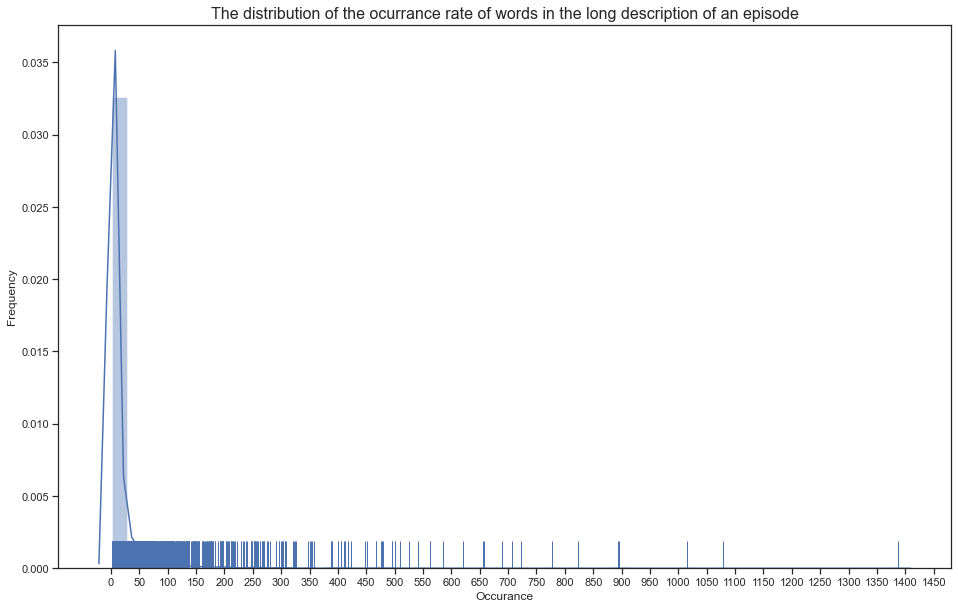

In [98]:
sns.distplot(list(Counter(desc_all_words).values()), rug=True)
plt.title("The distribution of the ocurrance rate of words in the long description of an episode",size=16)
plt.xlabel("Occurance")
plt.ylabel("Frequency")
plt.xticks(ticks=range(0,1500,50))
plt.show()

For the short description, these are the most common and least common words: 

In [99]:
short_all_words = []
for desc in df['short_desc']:
    for word in desc:
        short_all_words.append(word)

In [100]:
print("There is a total of {} unique words in the log description of all episodes".format(len(set(short_all_words))))

There is a total of 4059 unique words in the log description of all episodes


The 50 most common words are:

In [101]:
Counter(short_all_words).most_common(50)

[('get', 199),
 ('becom', 137),
 ('new', 131),
 ('take', 119),
 ('famili', 118),
 ('meanwhil', 110),
 ('find', 110),
 ('make', 97),
 ('school', 88),
 ('tri', 86),
 ('discov', 83),
 ('show', 79),
 ('help', 70),
 ('one', 69),
 ('plan', 67),
 ('town', 62),
 ('start', 61),
 ('name', 61),
 ('turn', 60),
 ('goe', 58),
 ('back', 56),
 ('friend', 56),
 ('day', 54),
 ('howev', 53),
 ('end', 51),
 ('give', 51),
 ('hous', 47),
 ('life', 45),
 ('time', 45),
 ('see', 44),
 ('work', 43),
 ('tell', 43),
 ('home', 42),
 ('want', 42),
 ('two', 42),
 ('plant', 41),
 ('like', 41),
 ('realiz', 40),
 ('win', 39),
 ('power', 38),
 ('littl', 38),
 ('call', 38),
 ('first', 37),
 ('soon', 37),
 ('come', 37),
 ('father', 37),
 ('use', 36),
 ('grampa', 36),
 ('love', 36),
 ('boy', 35)]

and the 50 most uncommon words are:

In [102]:
Counter(short_all_words).most_common()[:-50-1:-1]

[('covert', 1),
 ('barfli', 1),
 ('moefing', 1),
 ('imaginari', 1),
 ('bff', 1),
 ('reservoir', 1),
 ('cation', 1),
 ('root', 1),
 ('julia', 1),
 ('exclud', 1),
 ('predomin', 1),
 ('absenc', 1),
 ('unsupervis', 1),
 ('escal', 1),
 ('improvis', 1),
 ('butcher', 1),
 ('hotel', 1),
 ('sausag', 1),
 ('starv', 1),
 ('alley', 1),
 ('crude', 1),
 ('lombard', 1),
 ('des', 1),
 ('rue', 1),
 ('louvr', 1),
 ('preserv', 1),
 ('speci', 1),
 ('constrictor', 1),
 ('amazon', 1),
 ('lavatori', 1),
 ('cheapest', 1),
 ('gave', 1),
 ('impound', 1),
 ('came', 1),
 ('driveway', 1),
 ('motor', 1),
 ('morgan', 1),
 ('maintain', 1),
 ('motherhood', 1),
 ('canyon', 1),
 ('mom', 1),
 ('greet', 1),
 ('touristi', 1),
 ('understudi', 1),
 ('orchestr', 1),
 ('tenaci', 1),
 ('affect', 1),
 ('devast', 1),
 ('devious', 1),
 ('mar', 1)]

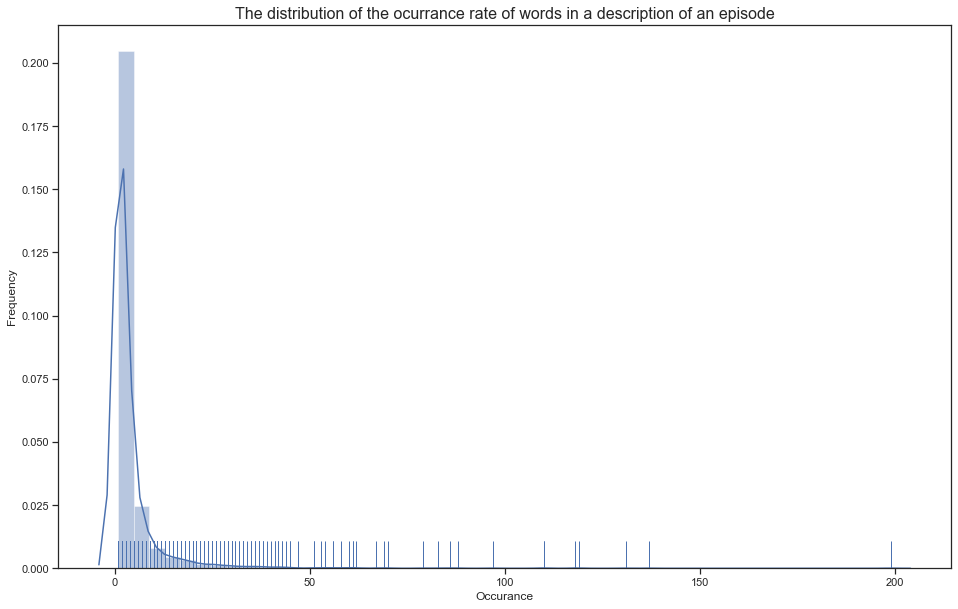

In [103]:
sns.distplot(list(Counter(short_all_words).values()), rug=True)
plt.title("The distribution of the ocurrance rate of words in a description of an episode",size=16)
plt.xlabel("Occurance")
plt.ylabel("Frequency")
plt.xticks(ticks=range(0,250,50))
plt.show()

After looking at the distribution of how often unique words occur in the long description and short description of episodes, words with a very high frequency and a very low frequency were removed from each episodes description.

For the long description, words occuring more than 250 times or less than 20 times will be removed. 

For the short description, words occuring less than 5 times or more than 100 times will be removed. 

In [104]:
desc_words_to_remove = []
for word in Counter(desc_all_words):
    if(Counter(desc_all_words)[word]>250 or Counter(desc_all_words)[word]<20):
        desc_words_to_remove.append(word)

In [105]:
short_desc_words_to_remove = []
for word in Counter(short_all_words):
    if(Counter(short_all_words)[word]>100 or Counter(short_all_words)[word]<5):
        short_desc_words_to_remove.append(word)

In [106]:
def remove_high_lo_freq(original_words, words_to_remove):
    for word in words_to_remove:
        while word in original_words:
            original_words.remove(word)
    return original_words

In [107]:
df['desc'] = df['desc'].apply(lambda x: remove_high_lo_freq(x, desc_words_to_remove))

In [108]:
df['short_desc'] = df['short_desc'].apply(lambda x: remove_high_lo_freq(x, desc_words_to_remove))

In [109]:
df['desc_len'] = df['desc'].apply(lambda x: len(x))
df['short_desc_len'] = df['short_desc'].apply(lambda x: len(x))

In [110]:
desc_all_words = []
for desc in df['desc']:
    for word in desc:
        desc_all_words.append(word)
        
Counter(desc_all_words).most_common(10)

[('littl', 249),
 ('drive', 248),
 ('run', 247),
 ('peopl', 247),
 ('love', 240),
 ('life', 238),
 ('choos', 234),
 ('year', 233),
 ('explain', 229),
 ('forc', 222)]

In [111]:
short_all_words = []
for desc in df['short_desc']:
    for word in desc:
        short_all_words.append(word)
        
Counter(short_all_words).most_common(10)

[('friend', 56),
 ('life', 45),
 ('plant', 41),
 ('win', 39),
 ('power', 38),
 ('littl', 38),
 ('father', 37),
 ('grampa', 36),
 ('love', 36),
 ('boy', 35)]

In order to represent the uniqueness of each episode and make the *textual data* more descriptive, *TF-IDF analysis* was considered. However, David M. Blei argues that LDA addresses the shortcomings of the TF-IDF analysis and leaves that approach behind [[REF]](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf). Thus, we decided against using TF-IDF analysis for our model. 

##  4. Descriptive Stats <a class="anchor" id="four"></a>

The final data set is comprised of 600 rows where each row represents an episode of *The Simpsons*, and 13 feature columns. Each episode gets an overall rating between 0.0 and 10.0, although the minimum and maximum ratings in this dataset are $3.9$ and $9.3$ respectively. 

Each episode (row) has a feature called `desc` which holds the words used to describe the episode thoroughly, and a column called `short_desc` which represent a shortened description found on each episode's wiki page. 

In [ ]:
df.shape

The following tables show some basic stats about the data set.

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
sns.lineplot(x='season',y='rating',data=df.groupby('season').mean()['rating'].reset_index())
plt.title("Average rating per season", size=16)
plt.xlabel("Season")
plt.ylabel("Average Rating")
plt.show()

In [ ]:
sns.scatterplot(x='no_overall',y='rating',data=df)
plt.title("Ratings of episodes", size=16)
plt.xlabel("No. of Episode")
plt.ylabel("Rating")
plt.show()

In [ ]:
ax = sns.heatmap(df[['rating','no_in_season','season']].pivot_table(columns='season',index='no_in_season',values='rating'),
                 annot=True,
                 cmap='coolwarm',
                linewidth=0.05,
                linecolor='black')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Heatmap showing the ratings for episodes", size=16)
plt.ylabel("Number of episode in season")
plt.xlabel("Season")
plt.show()

The past three plots visualize the decline over the years. While each season has its lowpoints, the quality (rating) of episodes has been going down over the past years. 

In [ ]:
ax = sns.heatmap(df.corr(), annot=True,vmin=0.0, vmax=1.0, cmap='coolwarm',linewidths=1) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Heatplot showing the correlation between variables", size=16)
plt.show()

There seems to be some correlation between how many are watching the episode and how highly it is rated. 

In [ ]:
sns.set_palette('rainbow')
sns.distplot(df['rating'], rug=True)
plt.title("Distribution of ratings of episodes", size=16)
plt.xlabel("Rating (0-10)")
plt.ylabel("Frequency")
plt.show()

Most episodes are scoring a rating between 6 and 8.5

In [ ]:
sns.distplot(df['mil_viewers'], rug=True)
plt.title("Distribution of viewers for the episodes", size=16)
plt.xlabel("Viewers (millions)")
plt.ylabel("Frequency")
plt.show()

Most episodes have around 5-15 million viewers. 

In [ ]:
sns.distplot(df[df['desc_len']>0]['desc_len'], rug=True)
plt.title("The Distribution of the Lenght of the Long Description of Episodes (non-unique words)", size=16)
plt.xlabel("Total Words in Description")
plt.ylabel("Frequency")
plt.show()

In [ ]:
sns.distplot(df[df['short_desc_len']>0]['short_desc_len'], rug=True)
plt.title("The Distribution of the Lenght of the Short Description of Episodes (non-unique words)", size=16)
plt.xlabel("Total Words in Description")
plt.ylabel("Frequency")
plt.show()

# 5. Linear Regression - For comparison <a class="anchor" id="reg"></a>

In order to see if the new topical model is more accurate than a normal linear regression model, a simple linear regression model was created in order to try and predict the rating of an episode. 

In [ ]:
df.columns

In [ ]:
X = df[['no_overall','no_in_season','season','mil_viewers']].values

In [ ]:
y = df['rating'].values

In [ ]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [ ]:
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
lm = LinearRegression()

In [ ]:
lm.fit(X_train,y_train)

In [ ]:
predictions = lm.predict(X_test)

In [ ]:
plt.scatter(y_test,predictions)
plt.title("Actual values vs. Predicted values of ratings of episodes", size=16)
plt.xlabel("Test value (Standardized)")
plt.ylabel("Predicted value (Standardized)")
plt.show()

In [ ]:
sns.distplot((y_test-predictions),bins=50);
plt.title("Distribution of residuals", size=16)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

From this it can be seen that creating a linear regression model in order to predict an episode's rating from other features is somewhat achievable.

# 6. Generative Story & PGM <a class="anchor" id="six"></a>

As we will deploy LDA for our topic model, the generative story for the inference of topics will follow the same generative story LDA follows. Here, we have changed the wording to fit our project. The following will be the generative story our model will follow: 

1. For each topic $k \in \{1,2,...,K\}$ where $K$ is the assumed total number of topics, there is a vector of $C$ words, $\phi_k$, such that $p(\theta_k|\beta) = \text{Dir}(\beta)$

2. For each document (*episode*) $i$:

>a) There is a vector of $K$ topics, $\theta_i$, such that $p(\theta_i|\alpha) = \text{Dir}(\alpha)$ 
    
>b) For each of the words $j$ in each episode $i$, where $j\in \{1,2,...,||w_i||\}$, we have
    
>>i) A **topic assignment** $z_{i,j} \in \{1,2,...,K\}$ such that $p(z_{i,j}|\theta_i) = \text{Cat}(\theta_i)$
    
>>ii) A **word** $w_{i,j}$ such that $p(w_{i,j}|\phi_{z_{i,j}}) = \text{Cat}(\phi_{z_{i,j}})$

What this means is that each episode will get assigned topic proportions and each topic will get assigned word proportions. 


### First version of our PGM

![title](lda_pgm_mkk.png)

The first version of our PGM is shown here above. We plan to build on top of it, create a dynamic topic model with inspo from [here](https://mimno.infosci.cornell.edu/info6150/readings/dynamic_topic_models.pdf)

# 7. Stan Model <a class="anchor" id="eight"></a>

### Full model, first version

In [299]:
LDA_STAN="""
data{
    int<lower=1> I; 
    int<lower=1> J[I];  // We mean J=||W_i||
    int<lower=2> K; // # of topics
    int<lower=2> C; 
    vector<lower=0>[K] alpha;
    vector<lower=0>[C] beta;
    int<lower=2> MAX_J;
    int W[I,MAX_J];
}

parameters{
    simplex[K] theta[I];
    simplex[C] phi[K];
}

model{
    for (k in 1:K)
        phi[k]~dirichlet(beta);
        
    for (i in 1:I){
        theta[i]~dirichlet(alpha);
        
        for (j in 1:J[i]){
                real gamma[K];
                for (k in 1:K)
                    // log(P(z = k | theta)) + log(P(W | phi, z = k)) 
                    gamma[k]=log(theta[i,k])+log(phi[k,W[i][j]]);
                
                target+=(log_sum_exp(gamma)); //likelihood
        }
    }
}

"""

## <font color=red>SKÍTAMIX að droppa þeim</font> 

In [332]:
df.drop(df[df.desc_len == 0].index, inplace = True) # preventing error in STAN when desc lenght = 0
df.reset_index(drop=True, inplace = True) 

I: number of documents (episodes)

In [333]:
I = len(df)
I

591

J = ||w_i|| : number of words in each episode

In [334]:
J = df['desc_len'].to_list()

This suggests to use K as 32

In [335]:
K = 32

C: number of words in our dictionary

In [336]:
dictionary = df.desc.explode().unique() 
C = len(dictionary)
C

1335

#### BOW 

In [338]:
numbered_dic = {ni: indi for indi, ni in enumerate(set(dictionary))}

w = np.zeros((I, np.max(J)), dtype=int )
for i in range(I): # I = number of episodes
    for j in range(J[i]): # J = number of words per episode
        w[i,j] = numbered_dic.get(df.desc[i][j])

In [339]:
w

array([[ 134, 1038,  538, ...,    0,    0,    0],
       [ 846,  811,  201, ...,    0,    0,    0],
       [ 356, 1166,  623, ...,    0,    0,    0],
       ...,
       [1126,  823,  528, ...,    0,    0,    0],
       [ 332,  740,   69, ...,    0,    0,    0],
       [ 414,  960, 1105, ...,    0,    0,    0]])

In [340]:
np.shape(w)

(591, 626)

In [341]:
print('I:',I)
print('J;',J)
print('K:',K)
print('C:',C)
print('alpha:',alpha)
print('beta',beta)
print('MAX_J',np.max(J))

I: 591
J; [578, 281, 340, 138, 168, 214, 228, 143, 238, 126, 93, 338, 265, 122, 226, 209, 186, 67, 104, 149, 95, 468, 89, 135, 128, 129, 149, 70, 133, 110, 91, 125, 87, 84, 111, 462, 144, 116, 134, 75, 225, 122, 145, 68, 136, 177, 29, 180, 148, 229, 98, 241, 110, 30, 24, 152, 93, 32, 250, 133, 128, 140, 350, 125, 134, 86, 130, 79, 201, 311, 61, 239, 145, 184, 289, 83, 103, 223, 153, 15, 216, 107, 74, 38, 22, 81, 114, 54, 159, 46, 65, 75, 114, 228, 87, 100, 119, 67, 91, 168, 73, 102, 99, 21, 152, 99, 553, 162, 80, 44, 62, 148, 49, 111, 118, 57, 93, 118, 229, 167, 92, 133, 165, 160, 92, 205, 180, 40, 220, 191, 242, 253, 45, 209, 147, 62, 44, 51, 88, 141, 74, 85, 109, 99, 54, 240, 419, 158, 154, 91, 199, 21, 1, 13, 82, 52, 116, 117, 193, 191, 49, 128, 86, 63, 69, 114, 96, 151, 135, 158, 230, 75, 248, 182, 56, 231, 104, 175, 30, 97, 111, 91, 109, 107, 157, 132, 92, 142, 104, 144, 131, 118, 87, 121, 68, 56, 103, 127, 71, 98, 118, 70, 292, 55, 147, 107, 85, 32, 186, 115, 13, 184, 111, 122, 1

In [342]:
alpha = np.ones(K)
beta = np.ones(C)

In [343]:
np.min(J)

1

In [344]:
## Compile and collect data
sm = pystan.StanModel(model_code=LDA_STAN)
data={'I':I, 'J':J, 'K':K, 'C':C, 'alpha':alpha, 'beta':beta, 'MAX_J':np.max(J), 'W':w+1}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b976da1749d3b34919bedb3ec5dbdb4 NOW.


In [345]:
## Sample with VB
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=100, grad_samples=20, seed=42, verbose=True)

Extract results from STAN:

In [346]:
theta_hat = pystan_utils.vb_extract_variable(fit, "theta", var_type="matrix", dims=[I,K])
phi_hat = pystan_utils.vb_extract_variable(fit, "phi", var_type="matrix", dims=[K,C])

In [348]:
np.argmax(phi_hat, axis=0)

array([ 6,  8, 16, ..., 30,  7, 13])

In [426]:
for i in range(30): #I:
    print("\n\nEpisode: ", i)
    print("max topic: ", np.argmax(theta_hat[i], axis=0))
    top20 = phi_hat[i].argsort()[-20:][::-1] # get the index of the 20 largest values
    for topword in top20:
        for word, number in numbered_dic.items():
            if number == topword:
                print(word)



Episode:  0
max topic:  5
santa
littl
dog
friend
buck
roof
let
suggest
ray
eventu
buy
choos
keep
bar
run
walk
impress
love
finish
hound


Episode:  1
max topic:  1
suggest
class
let
test
mrs
teacher
parent
children
offer
student
phone
decid
face
lawyer
father
friend
claim
admit
case
mother


Episode:  2
max topic:  10
game
win
team
church
friend
suggest
apart
footbal
everi
bowl
box
pick
learn
field
reverend
saxophon
let
dream
agre
announc


Episode:  3
max topic:  1
creatur
suggest
bender
pie
destroy
sinc
lead
shoot
transform
machin
includ
sever
vote
clone
role
box
queen
pumpkin
anoth
learn


Episode:  4
max topic:  21
stori
parodi
appear
hair
includ
dream
shoot
alien
die
although
world
father
bodi
death
peopl
suggest
chief
short
year
god


Episode:  5
max topic:  2
grampa
christma
present
mall
talk
bulli
race
friend
includ
trip
beat
let
fish
doll
retir
run
drive
suggest
announc
staci


Episode:  6
max topic:  7
polic
chief
state
point
walt
arrest
let
gun
face
shoot
law
mayor
tom
wel

# 8. Conclusion <a class="anchor" id="conclusion"></a>

Our research question;
> How do the topic proportions align with the episodes and can they be used to determine an episode's rating
